# Exploratory NB for Local Entropy Quantity
*******************

Word entropy is the entropy of the distribution given the full sequence history. **Local entropy** of a sequence is the average word entropy of a sequence. Estimated using logits from pretrained GPT3 model.

### Wired Dataset

The [wired dataset](https://www.youtube.com/playlist?list=PLibNZv5Zd0dyCoQ6f4pdXUFnpAIlKgm3N) is a very small collection of transcripts of a YouTube series where an expert explains a topic to audiences of different experience levels. **Results:** High variation in local entropy across topics means local entropy alone isn't a reliable indicator of target audience experience level. Within a topic, was able to order 70% of episodes correctly when ordering by increasing local entropy. These results appear impressive but are not very strong due to the size and quality of the dataset.


### Blog Age Dataset

The [blog age dataset](https://u.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf) is a collection of blog posts with age and gender information. **Results:** There appears to be a weak relationship between age or gender of poster and local entropy. Mean / variance accross set may be an interesting statistic when looking at many blog posts of the same age / type.


### Essay Scoring Dataset

The essay scores dataset ([ASAP](https://arxiv.org/pdf/2205.03835v2.pdf)) is a collection short essays and respective scores. **Results:** There appears to be a weak relationship between age of poster and local entropy. Mean / variance accross set may be an interesting statistic when looking at many essays of the same age / type.


*******************
TODO:
- clean wired text
- implement continuous entropy approx
- more datasets
- consider statistics accoss sets of text

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
# load model 
# https://huggingface.co/transformers/v4.8.2/_modules/transformers/models/gpt2/modeling_gpt2.html
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [3]:
# tokenizer example
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
tokenizer.decode(encoded_input['input_ids'][0])

"Replace me by any text you'd like."

In [4]:
# model example
# https://huggingface.co/transformers/v4.8.2/main_classes/output.html?highlight=causallmoutputwithcrossattentions#transformers.modeling_outputs.CausalLMOutputWithCrossAttentions
output = model(**encoded_input)
print(output.logits.shape)
best = torch.argmax(output.logits, dim=2)
tokenizer.decode(best[0])

torch.Size([1, 10, 50257])


'. the with a means, want like.\n'

In [74]:
# functions for local entropy calculation'

def word_entropy(logits, k):
    """entropy of conditinal distribution over each word"""
    logits = torch.topk(logits, k).values # approx distribution using top k words
    logits = logits.detach().numpy().astype(np.longdouble)
    p = 1/(1 + np.exp(-logits))
    p = p / p.sum(axis=2, keepdims=True) # rescale distribution
    entropy = (-p*np.log(p)).sum(axis=2)
    return entropy

def word_entropy_cont(logits, k=500):
    """entropy of conditinal distribution over each word assuming power law probability distribution"""
    pass

def local_entropy(logits, k=500, n=5):
    """average word entropy, ignoring first n words"""
    we = word_entropy(logits, k)
    if len(we[0][n:])>0:
        return we[0][n:].mean(), we[0][n:].std()
    return None, None

*******************
### Wired Dataset:

In [41]:
# load wired data
from pathlib import Path
import re

# text chunking for gpt
def chunk_text(txt, seq_len=800, overlap=20):
    txt_arry = txt.split()
    # chunk and return
    chunks = []
    i = 0
    while i<len(txt_arry):
        chunks.append(' '.join(txt_arry[i:i+seq_len]))
        i += seq_len - overlap
    return chunks

# text loading / preprocessing
def get_text(level, episode, season):
    # load text
    file = f"wired_transcript/s{season}e{episode}/{level}.txt"
    txt = Path(file).read_text()
    
    # clean text
    txt = re.sub('\n', ' ', txt)
    
    # chunk and return
    return chunk_text(txt)

get_text(1,1,1)

["do you know why we're here today because we're talking about science yes we're going to talk about science and we're going to talk about a very specific kind of science about people who study brains do you know what a brain is what is it things um so what we're going to talk about this is something that people study in the brain called the connect tone do you know that your body is made up of really tiny things called cells um yes okay well there's more cells in your brain like way more cells than than all the stars we can see and so what the connectome is is we'd like to know where every cell in your brain is and how it talks to every other cell in your brain that was awesome daniel thank you"]

In [75]:
# compute local entropy on wired data
episodes = [(e+1,1) for e in range(20)]

hist, hist_std = [], []
for e, s in episodes: # for each episode
    print(f'episode {e}', end='\r')
    ep_ents, ep_stds = [], []
    for lvl in range(5): # for each level
        txts = get_text(lvl+1, e, 1)
        ent, std, n = 0, 0, 0
        for txt in txts: # chunked text
            logits = model(**tokenizer(txt, return_tensors='pt', max_length=1024, truncation=True)).logits # get word logits
            le, le_std = local_entropy(logits) # get local entropy
            if le:
                ent += le
                std += le_std
                n += 1
        ep_ents.append(ent/n)
        ep_stds.append(std/n)
    hist.append(ep_ents)
    hist_std.append(ep_stds)

# save results
with open("wired_transcript/le.pkl", "wb") as f:
    pkl.dump((hist, hist_std), f)

In [76]:
with open("wired_transcript/le.pkl", "rb") as f:
    hist, hist_std = pkl.load(f)

0.04373808481578903
0.0037242203585634986


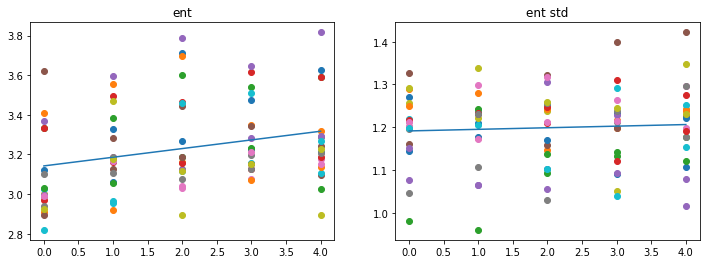

In [82]:
# plot results
fig, axs = plt.subplots(1,2, figsize=(12,4))

for ax, xi, t in zip(axs, [hist, hist_std], ['ent', 'ent std']):
    # get best fit line
    x, y = [], []
    for ep in xi:
        for i in range(5):
            x.append((i, 1))
            y.append(ep[i])
    m, c = np.linalg.lstsq(np.array(x).astype(float), np.array(y).astype(float), rcond=None)[0]
    print(m)

    # data points
    x = np.arange(5)
    for ep in xi:
        ax.scatter(x, ep)
    # best fit line
    ax.plot(x, m*x+c)
    
    ax.set_title(t)
    
plt.show()

In [83]:
# predict order within subject using local entropy scores
# get pct of correctly ordered episodes
correct, total = 0, 0

gt = np.arange(5)
for ep in hist:
    x = np.array(ep)
    d = x[1:]-x[:-1]
    s = d>0
    correct += s.sum()
    total += len(s)
    
correct / total

0.6375

******************
### Blog Dataset

In [84]:
# load age + text data
import json

with open('blog_age/test.json') as f:
    data = json.load(f)
data[0]

{'post': 'Thabo admits defeat on quiet diplomacy  Mbeki  urlLink stated  yesterday that his policy of quiet diplomacy on Zimbabwe has been a failure. Speaking through presidential spokesperson Bheki Khumalo, he said that the talks between the Zanu-PF and MDC were \'too slow\' and that no progress had been made on the issue.  However, Mbeki also stated that he would "press on with his diplomatic efforts in Zimbabwe despite fierce criticism, because he still believed there was no alternative to dialogue." These is a confusing sentiment. There are many political alternatives to dialogue that include simple public censure and economic pressure.  Mbeki has largely based himself as a foreign policy president, particularly in his first term, and to gain any credibility for NEPAD and his other strong foreign policy initiatives, he must take action on Zimbabwe. After his softening position on AIDS, it is the one factor in his presidency that the world still cannot understand. Struggle friends o

In [87]:
# compute local entropy on blog data
num_posts = 200

ents, ents_std, age, gender = [], [], [], []
for i,d in enumerate(data[:num_posts]): # for each post
    print(f'post {i}', end='\r')
    p, a, g = d['post'], d['age'], d['gender']

    # do entropy calc
    ent, ent_std, n = 0, 0, 0
    for txt in chunk_text(p): # chunked text
        logits = model(**tokenizer(txt, return_tensors='pt', max_length=1024, truncation=True)).logits # get word logits
        le, le_std = local_entropy(logits) # get local entropy
        if le:
            ent += le
            ent_std += le_std
            n += 1
            
    if n:
        ents.append(ent/n)
        ents_std.append(ent_std/n)
        age.append(a)
        gender.append(g)

# save results
with open("blog_age/le.pkl", "wb") as f:
    pkl.dump((ents, ents_std, age, gender), f)

In [88]:
with open("blog_age/le.pkl", "rb") as f:
    ents, ents_std, age, gender = pkl.load(f)

-0.010611669967023571
0.004663067024501555


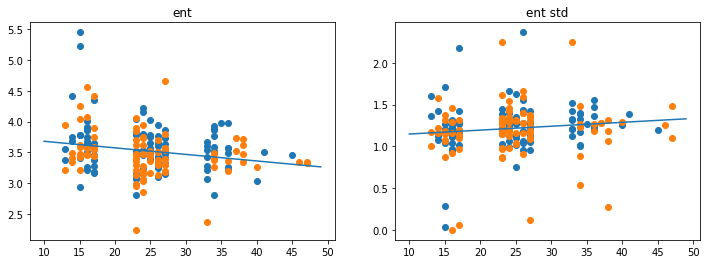

In [89]:
# plot results
fig, axs = plt.subplots(1,2, figsize=(12,4))

for ax, xi, t in zip(axs, [ents, ents_std], ['ent', 'ent std']):

    # get best fit line
    x, y = [], []
    for e, a in zip(xi, age):
        x.append((float(a), 1))
        y.append(e)
    m, c = np.linalg.lstsq(np.array(x).astype(float), np.array(y).astype(float), rcond=None)[0]
    print(m)

    # data points
    for l in ['male','female']:
        ax.scatter([int(age[i]) for i,g in enumerate(gender) if g==l], [xi[i] for i,g in enumerate(gender) if g==l], label=l)
    # best fit line
    x = np.arange(10,50)
    ax.plot(x, m*x+c)
    
    ax.set_title(t)
    
plt.show()

***************
### Essay Scores Dataset

In [90]:
# load essay data
from datasets import load_dataset

data = load_dataset("Ericwang/ASAP", split='1')
data[0]

Using custom data configuration Ericwang--ASAP-365c9c63a4af1585
Reusing dataset parquet (/home/jeremy_arsenault/.cache/huggingface/datasets/parquet/Ericwang--ASAP-365c9c63a4af1585/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


{'essay': "Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about 

In [91]:
# compute local entropy on blog data
num_essays = 200

ents, ents_std, score = [], [], []
for i in range(min(num_essays, len(data))): # for each essay
    print(f'essay {i}', end='\r')
    e, s = data[i]['essay'], data[i]['score']

    # do entropy calc
    ent, ent_std, n = 0, 0, 0
    for txt in chunk_text(e): # chunked text
        logits = model(**tokenizer(txt, return_tensors='pt', max_length=1024, truncation=True)).logits # get word logits
        le, le_std = local_entropy(logits) # get local entropy
        if le:
            ent += le
            ent_std += le_std
            n += 1
            
    if n:
        ents.append(ent/n)
        ents_std.append(ent_std/n)
        score.append(s)

# save results
with open("essay_scoring/le.pkl", "wb") as f:
    pkl.dump((ents, ents_std, score), f)

In [92]:
with open("essay_scoring/le.pkl", "rb") as f:
    ents, ents_std, score = pkl.load(f)

-0.03188660066668329
0.025022028026895734


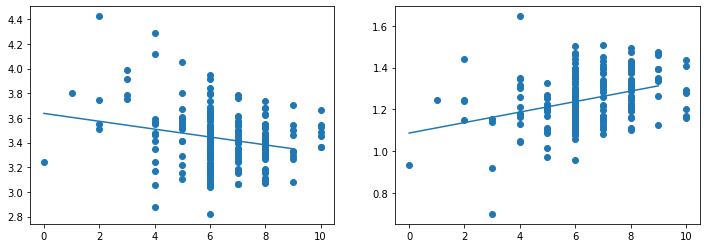

In [93]:
# plot results
fig, axs = plt.subplots(1,2, figsize=(12,4))

for ax, xi, t in zip(axs, [ents, ents_std], ['ent', 'ent std']):

    # get best fit line
    x, y = [], []
    for e, s in zip(xi, score):
        x.append((s, 1))
        y.append(e)
    m, c = np.linalg.lstsq(np.array(x).astype(float), np.array(y).astype(float), rcond=None)[0]
    print(m)

    # data points
    ax.scatter(score, xi)
    # best fit line
    x = np.arange(10)
    ax.plot(x, m*x+c)
    
plt.show()